# MG28894-1 Zr4_RD_FC_BB data analysis

In [1]:
# Import stuff

import ipywidgets as widgets
from ipywidgets import Button, Layout, Dropdown
from IPython.display import display
from nexusformat.nexus import *
import pyFAI, fabio, h5py
import matplotlib.pyplot as plt
import numpy as np
import glob, os
import bz2
import dill
from xrd_tools import *
import pickle

%matplotlib notebook
# %matplotlib widget
# %matplotlib qt

In [2]:
zr_peak_name, zr_peak_pos = getReflections(crystalType='hcp', outputType='d', a=3.232, c=5.147, wavelength=0.13776022048133363, printReflections=False)
delta_peak_name, delta_peak_pos = getReflections(crystalType='fcc',outputType='d',a=4.78395, wavelength=0.13776022048133363,printReflections=False)
gamma_peak_name, gamma_peak_pos = getReflections(crystalType='fct',outputType='d',a=4.66622, c=4.83862,wavelength=0.13776022048133363, printReflections=False)
zr_peak_ttheta = getReflections(crystalType='hcp',outputType='2theta',a=3.232, c=5.147, wavelength=0.13776022048133363, printReflections=False)
delta_peak_ttheta = getReflections(crystalType='fcc',outputType='2theta', a=4.78395, wavelength=0.13776022048133363, printReflections=False)
gamma_peak_ttheta = getReflections(crystalType='fct', outputType='2theta', a=4.586,  c=4.948, wavelength=0.13776022048133363, printReflections=False)
# zr_peak_ttheta
# delta_peak_ttheta

In [3]:
# Define paths
data_dir = r'Z:\Diamond_MG28894-1_DATA_BACKUP\rawdata'
cal_dir = r"Z:\Diamond_MG28894-1_DATA_BACKUP\processing"
ponifile_1050mm = cal_dir + "\MG28894-1_poni_1050.poni"
ponifile_2350mm = cal_dir + "\MG28894-1_poni_2350.poni"
ponifile_750mm = cal_dir + "\MG28894-1_poni_750.poni"

# Load experiments list:

In [4]:
with open('Diamond_experiments.pkl', 'rb') as f:
    Samples = pickle.load(f)
    
experiment_scanIDs = sorted([str(value[0]) for value in Samples.values() if value[0] != None])
experiment_keys = sorted(key for key in Samples.keys())

In [5]:
drop_down = Dropdown(options=experiment_keys, value=experiment_keys[0], description='scanID:', disabled=False, 
                             layout=Layout(width='40%'), style={'description_width': 'initial'})

def dropdown_handler(change):
    global scanID
    scanID = change.new
    scanID = str(Samples[scanID][0])
drop_down.observe(dropdown_handler, names='value')
display(drop_down)

Dropdown(description='scanID:', layout=Layout(width='40%'), options=('PuerZr_WQ_400_1mm_#1', 'PuerZr_WQ_400_1m…

In [ ]:
### List ALL directories in the root directory, newest first ###

dir_list=[name.split('\\')[-1].split(".")[0] for name in sorted(glob.glob(data_dir + '\*.nxs'))]
drop_down = Dropdown(options=dir_list, value=dir_list[0], description='scanID:', disabled=False, 
                             layout=Layout(width='40%'), style={'description_width': 'initial'})

def dropdown_handler(change):
    global scanID
    scanID = change.new
drop_down.observe(dropdown_handler, names='value')
display(drop_down)

### Check file:

In [ ]:
scanID

In [ ]:
### get metadata ###

fname = data_dir + "\\" + scanID + ".nxs"
metadata = nxload(fname)
# print(metadata.tree)

load = metadata.entry1.instrument.adc01_06.adc01_06
pos = metadata.entry1.instrument.adc01_07.adc01_07
temp = metadata.entry1.instrument.adc01_08.adc01_08

In [ ]:
### plot metadata ###

%matplotlib inline

fig, (ax) = plt.subplots(1,1, figsize=(8, 6))
axb = ax.twinx()

ax.plot(list(range(0,len(load))), [x*200 for x in load], color="tab:blue", label="load")
axb.plot(list(range(0,len(pos))), [x*0.5 for x in pos], color="tab:orange", label="position")
ax.plot(list(range(0,len(temp))), [x*150 for x in temp], color="tab:green", label="temperature")
ax.set_ylabel("Temperature [C]/ Load [N]")
axb.set_ylabel("Position [mm]")
ax.legend(loc="upper left")
axb.legend(loc="upper right")
ax.set_ylim(0,1000)
axb.set_ylim(-1, 8)
# ax.set_xlim(150, 180)

In [ ]:
### plot diffaction image ###

frame = 1
img_file = data_dir + "\\" + scanID + "-pilatus2M-files" + "\\" + str(frame).zfill(5) +".tif"
img = fabio.open(img_file)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img.data, vmax=75, origin="lower")
plt.tight_layout()

# Load ponifile

## ** double check distance **

In [7]:
ai = pyFAI.load(ponifile_2350mm)

## Plot with slider

In [8]:
### load all frames for selected experiment ###

frames = glob.glob(data_dir + "\\" + scanID + "-pilatus2M-files" + "\\" + "*")
frames = np.array(sorted([int(name.split('\\')[-1].split(".")[0]) for name in frames]))
frames = list(frames)
print(frames[1:10])

[2, 3, 4, 5, 6, 7, 8, 9, 10]


Z:\Diamond_MG28894-1_DATA_BACKUP\rawdata\108909-pilatus2M-files\


<IPython.core.display.Javascript object>


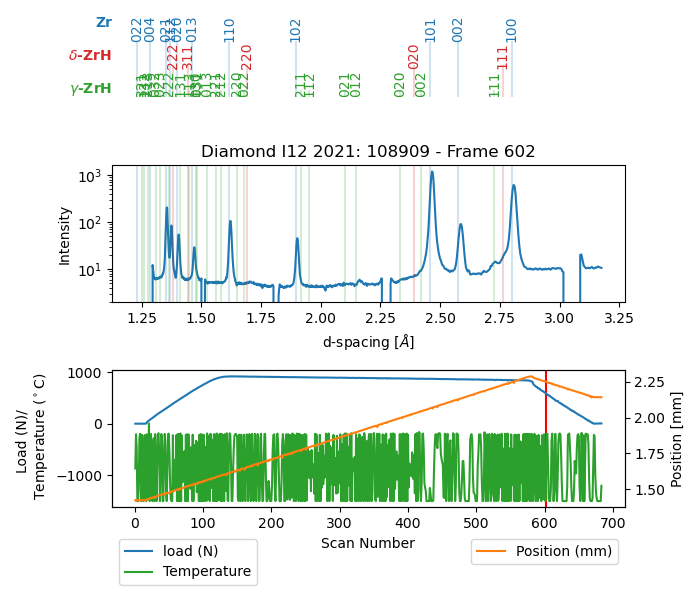

interactive(children=(SelectionSlider(description='Scan number:', layout=Layout(width='50%'), options=(1, 2, 3…

In [9]:
%matplotlib widget
################# set filepath and file format for get_data()

fpath = data_dir + "\\" + scanID + "-pilatus2M-files" + "\\" 
fileformat = ".tif"
metadata_path = data_dir + "\\" + scanID
metadata_format = ".nxs"
print(fpath)

################### set up plot

fig, (lax, ax, ax2) = plt.subplots(3,1, gridspec_kw={'height_ratios': [3, 5, 5]}, figsize = (7, 6))
lax.get_shared_x_axes().join(lax, ax)

vline = ax2.axvline(frames[0], c='r')

################### set up widget

@widgets.interact(scan_num=widgets.SelectionSlider(options=frames, description='Scan number:', disabled=False, 
                                                   layout=Layout(width='50%'), style={'description_width': 'initial'}))
def update_plot(scan_num=1):    
    # Top plot
    # Remove old lines from plot
    ax.cla()
    lax.cla()
    [t.set_visible(False) for t in ax.texts]

    data = get_data(scan_num, fpath, fileformat, metadata_path, metadata_format, ai, partial_rings=True)
    ax.plot(data['d_A'], data['intensity'], color='C0')

    ax.set_yscale('log')
    ax.set_title('Diamond I12 2021: {0} - Frame {1}'.format(scanID,scan_num), fontsize=12)
    ax.set_xlabel('d-spacing [$\AA$]'); ax.set_ylabel('Intensity');
    
    addLabels(ax, lax, ["Zr", '$\delta$-ZrH', '$\gamma$-ZrH'], [list(zr_peak_name), list(delta_peak_name), list(gamma_peak_name)],
              [list(zr_peak_pos), list(delta_peak_pos), list(gamma_peak_pos)], ["tab:blue", "tab:red", "tab:green"])
    vline.set_xdata(scan_num)
    print(scan_num)
    print(data['d_A'])
    return

### lower plot ###

data = get_data(1, fpath, fileformat, metadata_path, metadata_format, ai, partial_rings=True)
ax2.plot(frames[:-1], [x for x in data["metadata"]["load"]], label='load (N)', c="tab:blue")
ax2.plot(frames[:-1], [x for x in data["metadata"]["temp"]], label='Temperature', c = "tab:green")
ax2.legend(loc='upper left', bbox_to_anchor=(0, -0.18))
ax2.set_xlabel('Scan Number')
ax2.set_ylabel('Load (N)/ \n Temperature ($^\circ$C)')

ax2b = ax2.twinx()
ax2b.plot(frames[:-1], [x for x in data["metadata"]["position"]], label='Position (mm)', c='tab:orange')
ax2b.set_ylabel("Position [mm]")
ax2b.legend(loc='upper right', bbox_to_anchor=(1, -0.18))

## XRDfit

In [ ]:
from xrdfit.spectrum_fitting import PeakParams, FitSpectrum, FittingExperiment
%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (9, 6)

In [ ]:
test_frame = 1
caked_data_dir = r"Z:/Diamond_MG28894-1_DATA_BACKUP/processing/Integrated/" 
test = caked_data_dir + scanID + '/' + f'{test_frame:05d}' + ".txt"
test = caked_data_dir + "108800/00001.txt"
print(test)

In [ ]:
first_cake_angle = 0
spectral_data = FitSpectrum(test, first_cake_angle)
# fig = plt.figure(figsize=(14, 14))

In [ ]:
fig = plt.figure(figsize=(8,8))
spectral_data.plot_polar()

In [ ]:
spectral_data.plot([10, 19], 
                   x_range=(2,6.5), 
                   show_points=True, 
                   log_scale=True)

In [ ]:
# peak_params_zr = []
# peak_params_delta = []
# peak_params_gamma = []

# for pk, pos, in zip(zr_peak_name[:10], zr_peak_ttheta[1][:10]):
#     pk = str(pk[:2] + str((int(pk[0])+int(pk[1]))*-1) + pk[-1])
#     pk_bound_left = str('{:.3f}'.format(pos-0.05))
#     pk_bound_right = str('{:.3f}'.format(pos+0.05))
#     pk_max_left = str('{:.3f}'.format(pos-0.04))
#     pk_max_right = str('{:.3f}'.format(pos))
#     param = "PeakParams('(" + str(pk) + ")'" + ', (' + str(pk_bound_left) + ',' + str(pk_bound_right) + '), [(' + str(pk_max_left) + ',' + str(pk_max_right) + ')]),'
#     peak_params_zr.append(param)
    
# for pk, pos, in zip(delta_peak_name[:5], delta_peak_ttheta[1][:5]):
#     pk = pk
#     pk_bound_left = str('{:.3f}'.format(pos-0.05))
#     pk_bound_right = str('{:.3f}'.format(pos+0.05))
#     pk_max_left = str('{:.3f}'.format(pos-0.03))
#     pk_max_right = str('{:.3f}'.format(pos+0.01))
#     param = "PeakParams('d(" + str(pk) + ")'" + ', (' + str(pk_bound_left) + ',' + str(pk_bound_right) + '), [(' + str(pk_max_left) + ',' + str(pk_max_right) + ')]),'
#     peak_params_delta.append(param)
    
# for pk, pos, in zip(gamma_peak_name[2:23], gamma_peak_ttheta[1][2:23]):
#     pk = pk
#     pk_bound_left = str('{:.3f}'.format(pos-0.05))
#     pk_bound_right = str('{:.3f}'.format(pos+0.05))
#     pk_max_left = str('{:.3f}'.format(pos-0.03))
#     pk_max_right = str('{:.3f}'.format(pos+0.01))
#     param = "PeakParams('g(" + str(pk) + ")'" + ', (' + str(pk_bound_left) + ',' + str(pk_bound_right) + '), [(' + str(pk_max_left) + ',' + str(pk_max_right) + ')]),'
#     peak_params_gamma.append(param)
    
# # print(peak_params_zr, "\n\n", peak_params_delta, "\n\n", peak_params_gamma)
# for a in peak_params_zr:
#       print(a)
# print("\n")
# for a in peak_params_delta:
#       print(a)
# print("\n")        
# for a in peak_params_gamma:
#       print(a)

In [ ]:
plt.rcParams["figure.figsize"] = (12, 6)

##################################################################################
peak_params_combined = [
 PeakParams('(10-10), d(111), g(111)', (2.70,2.961), [(2.795,2.830),
                                                       (2.85,2.88),
                                                       (2.881,2.921)]),
 PeakParams('(0002), SPP, (10-11), d(020)', (3.017,3.390), [(3.04,3.063),
                                                            (3.12, 3.14),
                                                            (3.180,3.220),
                                                            (3.285,3.310)
                                                           ]),
 PeakParams('g(012)', (3.636,3.70), [(3.65,3.676)]),
 PeakParams('(10-12)', (4.05,4.217), [(4.137,4.1655)]),
 PeakParams('d(220), (11-20)', (4.6,4.936), [(4.650,4.705), (4.856,4.89)]),
 PeakParams('(01-13), d(311), (02-20), (11-22), (02-21)', (5.348,5.897), [(5.358,5.398),
                                                                          (5.455,5.5),
                                                                          (5.605,5.642),
                                                                          (5.730,5.770),
                                                                          (5.807,5.847)]),
 PeakParams('(0004)', (6.065,6.187), [(6.097,6.12)])
]

######################################################################################

peak_params_1 = [PeakParams('(10-10)', (2.8, 3.01), [(2.96, 3.0)]),
                 PeakParams('D(111)', (3.016, 3.075), [(3.02, 3.06)]),
                 #PeakParams('G(111)', (3.075, 3.1), [(3.075, 3.1)]),
                 #PeakParams('(0002)', (3.16, 3.3)),
                 #PeakParams('(10-11)', (3.3, 3.5))
                ]

peak_params_2 = [PeakParams('(10-10)', (2.8, 3.0), [(2.96, 3.0)]),
               PeakParams('D(111)', (3.01, 3.047), [(3.01, 3.035)]),
               PeakParams('G(111)', (3.054, 3.1), [(3.054, 3.08)]),
               #PeakParams('(0002)', (3.3, 3.5))
                ]

plt.yscale("log")


cakes_to_fit = [9, 10, 11, 27, 28, 29]
plt.yscale("log")

# peak_params = peak_params_1
# peak_params = peak_params_2
# peak_params = peak_params_zr
# peak_params = peak_params_delta
# peak_params = peak_params_gamma
peak_params = peak_params_combined

xrange_min = vars(peak_params[0])['peak_bounds'][0]-0.1
xrange_max = vars(peak_params[-1])['peak_bounds'][1]+0.1
spectral_data.plot_peak_params(peak_params, cakes_to_fit, (xrange_min, xrange_max), merge_cakes=True)

for i, peak in enumerate(peak_params):
    xrange_min = vars(peak_params[i])['peak_bounds'][0]-0.1
    xrange_max = vars(peak_params[i])['peak_bounds'][1]+0.1
    plt.yscale("log")
    spectral_data.plot_peak_params(peak_params, cakes_to_fit, (xrange_min, xrange_max), merge_cakes=True)


In [ ]:
spectral_data.fit_peaks(peak_params, cakes_to_fit, merge_cakes=True)

for fit in spectral_data.fitted_peaks:
    #plt.yscale("log")
    fit.plot(log_scale=True)

# Fit ALL frames

In [ ]:
##### ALL Frames #####
"""
spectrum_time = 1
file_stub = "Integrated" + str(sample_name) + '/*'
first_cake_angle = 0
cakes_to_fit = [1, 2, 18, 19, 20, 36]

experiment = FittingExperiment(spectrum_time, file_stub, first_cake_angle, cakes_to_fit, peak_params, merge_cakes=True)

experiment.run_analysis()
"""

## Overwrite frames list & metadata to include only the frames successfully integrated

In [ ]:
frames = glob.glob("Integrated_" + str(sample_name) + '/*')
frames = sorted([int(frame.split('/')[-1].split('.')[0]) for frame in frames])

metadata_list = [h5py.File(root_dir + sample_name + '/ma4751_' + sample_name + '.h5', mode='r')[sample_name + '_0001_' + str(scan_num) + '.1'] for scan_num in frames]

eng_strains = []
loads = []
temperatures = []

for i, meta in enumerate(metadata_list):
    try:
        eng_strains.append(np.mean(meta['measurement']['AI1'][()]/0.1))
        loads.append(np.mean(meta['measurement']['AI2'][()]*0.2))
        temperatures.append(np.mean(meta['measurement']['AI3'][()]*49.996))
    except:
        #print(i)
        names = np.delete(names, i)
        pass

# Fit: Defined subset of frames

In [ ]:
identifier = "_Zr+d+g_"

In [ ]:
start_frame = frames[0]
end_frame = frames[-1]

ttheta_range_start = "pt".join('{:.1f}'.format(vars(peak_params_1[0])['peak_bounds'][0]).split("."))
ttheta_range_stop = "pt".join('{:.1f}'.format(vars(peak_params_1[-1])['peak_bounds'][1]).split("."))

fsave = sample_name + identifier + str(ttheta_range_start) + "-" + str(ttheta_range_stop) + "_frames" + str(start_frame) + "-" + str(end_frame) + ".dump"
fsave

In [ ]:
##### Defined subset of frames ####


frames_to_load = list(frames)[list(frames).index(int(start_frame)):list(names).index(int(end_frame))]

spectrum_time = 1
file_stub = r"Integrated_" + str(sample_name) + '/{:05d}' + ".txt"

experiment = FittingExperiment(spectrum_time, file_stub, first_cake_angle, cakes_to_fit, peak_params, 
                               frames_to_load = frames_to_load, merge_cakes=True)

experiment.run_analysis(reuse_fits=True)
experiment.save(fsave)

In [ ]:
with bz2.open(fsave, "rb") as input_file:
    data = dill.load(input_file)
    print("Data successfully loaded from dump file.")
    
experiment = data

In [ ]:
#### for each fit, plot maximum_1_cntr for each peak
def plt_cntrs(experiment):
    for peak_fit in experiment.peak_names():

        for i, peak in enumerate(peak_fit.split(', ')):
            print(peak)
            fit_parameter = "maximum_" + str(i+1) + "_center"
            experiment.plot_fit_parameter(peak_fit, fit_parameter)
            
plt_cntrs(experiment)

In [ ]:
#### for each fit, plot maximum_1_cntr for each peak ontop of each other

def plt_cntrs_sbs(experiment):
    for peak_fit in experiment.peak_names():
        fig, ax = plt.subplots()
        # generate list of fit_parameters
        for i, peak in enumerate(peak_fit.split(', ')):
            fit_parameter = "maximum_" + str(i+1) + "_center"
            ax.plot(experiment.get_fit_parameter(peak_fit, fit_parameter)[:, 0], 
                    experiment.get_fit_parameter(peak_fit, fit_parameter)[:, 1], label = peak)
            ax.legend()
            
plt_cntrs_sbs(experiment)

In [ ]:
#plt.yscale("log")
experiment.plot_fits(num_timesteps = 20, log_scale=True)

In [ ]:
### Peak strains ###

### change for alll peaks ###

start_pos = dict()
for peak_fit in experiment.peak_names():
    for i, peak in enumerate(peak_fit.split(', ')):
        pk_parameter = "maximum_" + str(i+1) + "_center"
        start_pos[peak] = experiment.get_fit_parameter(peak_fit, pk_parameter)[0, 1]

In [ ]:
pk_strains = dict()
for peak_fit in experiment.peak_names():
    for i, peak in enumerate(peak_fit.split(', ')):
        pk_parameter = "maximum_" + str(i+1) + "_center"
        pk_strains[peak] = [(twotheta2d(ttheta) - twotheta2d(start_pos[peak])) / twotheta2d(start_pos[peak]) for ttheta in experiment.get_fit_parameter(peak_fit, pk_parameter)[:, 1]]

In [ ]:
pk_strains

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 9))

ax1.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['(10-10)']])
ax2.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['D(111)']])
#ax3.plot(frames_to_load[1:], strains_1['G(111)'])

ax3.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], [strain*10**6 for strain in strains_1['(10-10)']])
ax4.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], [strain*10**6 for strain in strains_1['D(111)']])
#ax3.plot(frames_to_load[1:], strains_1['G(111)'])

In [ ]:
from matplotlib.ticker import AutoMinorLocator

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4.5), sharey=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
#ax2.xaxis.set_minor_locator(AutoMinorLocator(4))
ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

titlesize = 20
subtitlesize = 16
axislabelsize = 16

main_title = r'Lattice Strain in FC-RXA-Zr4'
ax1_title = r'$\alpha$-(10$\bar1$0)'
ax2_title = r'$\delta$-ZrH (111)'
ylabel = r'Lattice Strain [$10^{-6}$]'
#plt.suptitle(main_title, fontsize=titlesize)
ax1.set_title(main_title, fontsize=titlesize)
#ax2.set_title(ax2_title, fontsize=subtitlesize)
ax1.set_xlabel('Engineering Strrain [%]', fontsize = axislabelsize)
ax1.set_ylabel(ylabel, fontsize = axislabelsize)
#fig.text(0.04, 0.5, ylabel, fontsize = axislabelsize, va='center', rotation='vertical')

# ax1.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['(10-10)']], label=ax1_title)
# ax1.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['D(111)']], label=ax2_title)

ax1.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], 
         [strain*10**6 for strain in strains_1['(10-10)']], label=ax1_title)
ax1.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], 
         [strain*10**6 for strain in strains_1['D(111)']], label=ax2_title)

plt.legend(loc=2)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

## Does Peak_Params not update the boundaries? 

In [ ]:
##### Defined subset of frames ####

"""
start_frame = 1310
end_frame = 1500
frames_to_load = list(names)[list(names).index(int(start_frame)):list(names).index(int(end_frame))]

spectrum_time = 1
file_stub = r"Integrated" + str(sample_name) + '/{:05d}' + ".txt"
first_cake_angle = 0
cakes_to_fit = [1, 2, 18, 19, 20, 36]

experiment = FittingExperiment(spectrum_time, file_stub, first_cake_angle, cakes_to_fit, peak_params, 
                               frames_to_load = frames_to_load, merge_cakes=True)

experiment.run_analysis(reuse_fits=True)
"""

In [ ]:
for peak_name in experiment.peak_names():
    experiment.plot_fit_parameter(peak_name, "maximum_1_center")

In [ ]:
plt.yscale("log")
experiment.plot_fits(num_timesteps = 20)

## Build loop to fit spectra & update all boundaries (with increment of 10-10 shift?)

### First Load

In [ ]:
###### First Load ######

start_frame = 7
end_frame = 876
frames_to_load_1 = list(names)[list(names).index(int(start_frame)):list(names).index(int(end_frame))]

fits_list_1 = []

test_frame = frames_to_load_1[0]
test_file = "Integrated_" + str(sample_name) + '/' + f'{test_frame:05d}' + ".txt"
#test_file = dir_name + "/" + f'{test_file:05d}' + ".txt"
print(test_file)

spectral_data_1 = FitSpectrum(test_file, 0)

peak_params_1 = [PeakParams('(10-10)', (2.8, 3.01), [(2.96, 3.0)]),
               PeakParams('D(111)', (3.016, 3.075), [(3.02, 3.06)]),
               #PeakParams('G(111)', (3.075, 3.1), [(3.075, 3.1)]),
               #PeakParams('(10-11)', (3.3, 3.5))
                ]

spectral_data_1.fit_peaks(peak_params_1, [9, 10, 11, 27, 28, 29], merge_cakes=True)

peak_centre_start = spectral_data_1.get_fit("(10-10)").result.values['maximum_1_center']
print(peak_centre_start)
# for fit in spectral_data_1.fitted_peaks:
#     plt.yscale("log")
#     fit.plot()


for frame in frames_to_load_1[1:]:
    test_file = "Integrated_" + str(sample_name) + '/' + f'{frame:05d}' + ".txt"
    print(test_file)
    
    spectral_data_1 = FitSpectrum(test_file, 0)
    
    spectral_data_1.fit_peaks(peak_params_1, [9, 10, 11, 27, 28, 29], merge_cakes=True)
    
    peak_centre_new = spectral_data_1.get_fit("(10-10)").result.values['maximum_1_center']
    peak_strain = peak_centre_new - peak_centre_start
    print(peak_centre_new, '\t', peak_strain)
    
    Zr_shift = peak_strain
    ZrH_shift_RHS = peak_strain*3
    ZrH_shift_LHS = peak_strain*1.5
    
    peak_params_1 = [PeakParams('(10-10)', (2.8 + Zr_shift, 3.01 + Zr_shift), [(2.96 + Zr_shift, 3.0 + Zr_shift)]),
               PeakParams('D(111)', (3.016 + ZrH_shift_LHS, 3.075 + ZrH_shift_RHS), [(3.02 + ZrH_shift_LHS, 3.06 + ZrH_shift_RHS)]),
               #PeakParams('G(111)', (3.054 + peak_strain, 3.1 + peak_strain), [(3.054 + peak_strain, 3.08 + peak_strain)]),
               #PeakParams('(10-11)', (3.3 + Zr_shift, 3.5 + Zr_shift))
                    ]
    
    for params in peak_params_1:
        print(params)
    
#     for fit in spectral_data_1.fitted_peaks:
#         plt.yscale("log")
#         fit.plot()
        
    fits_list_1.append(spectral_data_1)
    

In [ ]:
### Peak strains ###

start_positions_1 = {'(10-10)': fits_list_1[0].get_fit("(10-10)").result.values['maximum_1_center'],
                   'D(111)': fits_list_1[0].get_fit('D(111)').result.values['maximum_1_center'],
                   #'G(111)': fits_list_1[0].get_fit('G(111)').result.values['maximum_1_center']
                  }

def twotheta2d(ttheta):
    return 0.13776022048133363/(2*np.sin(np.deg2rad(ttheta/2)))

strains_1 = {'(10-10)': [(twotheta2d(ttheta.get_fit("(10-10)").result.values['maximum_1_center']) 
                         - twotheta2d(start_positions_1['(10-10)']))/twotheta2d(start_positions_1['(10-10)'])
                         for ttheta in fits_list_1],
            'D(111)': [(twotheta2d(ttheta.get_fit('D(111)').result.values['maximum_1_center']) 
                       - twotheta2d(start_positions_1['D(111)']))/twotheta2d(start_positions_1['D(111)'])
                       for ttheta in fits_list_1],
            #'G(111)': [twotheta2d(ttheta.get_fit('G(111)').result.values['maximum_1_center']) - twotheta2d(start_positions_1['G(111)']) for ttheta in fits_list_1]
          }

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 9))

ax1.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['(10-10)']])
ax2.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['D(111)']])
#ax3.plot(frames_to_load[1:], strains_1['G(111)'])

ax3.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], [strain*10**6 for strain in strains_1['(10-10)']])
ax4.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], [strain*10**6 for strain in strains_1['D(111)']])
#ax3.plot(frames_to_load[1:], strains_1['G(111)'])

In [ ]:
from matplotlib.ticker import AutoMinorLocator

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4.5), sharey=True)
ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
#ax2.xaxis.set_minor_locator(AutoMinorLocator(4))
ax1.yaxis.set_minor_locator(AutoMinorLocator(4))

titlesize = 20
subtitlesize = 16
axislabelsize = 16

main_title = r'Lattice Strain in FC-RXA-Zr4'
ax1_title = r'$\alpha$-(10$\bar1$0)'
ax2_title = r'$\delta$-ZrH (111)'
ylabel = r'Lattice Strain [$10^{-6}$]'
#plt.suptitle(main_title, fontsize=titlesize)
ax1.set_title(main_title, fontsize=titlesize)
#ax2.set_title(ax2_title, fontsize=subtitlesize)
ax1.set_xlabel('Engineering Strrain [%]', fontsize = axislabelsize)
ax1.set_ylabel(ylabel, fontsize = axislabelsize)
#fig.text(0.04, 0.5, ylabel, fontsize = axislabelsize, va='center', rotation='vertical')

# ax1.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['(10-10)']], label=ax1_title)
# ax1.plot(frames_to_load_1[1:], [strain*10**6 for strain in strains_1['D(111)']], label=ax2_title)

ax1.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], 
         [strain*10**6 for strain in strains_1['(10-10)']], label=ax1_title)
ax1.plot(eng_strains[frames_to_load_1[0]:frames_to_load_1[-3]], 
         [strain*10**6 for strain in strains_1['D(111)']], label=ax2_title)

plt.legend(loc=2)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

In [ ]:
### Double check fits

plt.rcParams["figure.figsize"] = (6, 4)

step = 2
for frame_ID, frame in zip(frames_to_load_1[450:550:step], fits_list_1[::step]):
    #print(frame_ID)
    for fit in frame.fitted_peaks:
        plt.yscale("log")
        print('Frame_ID: ' + f'{frame_ID:d}')
        fit.plot()

In [ ]:
### Douuble check peak_params ###

plt.rcParams["figure.figsize"] = (6,4)

test_frame = 7
#test_frame = 889
test_file = "Integrated_" + str(sample_name) + '/' + f'{test_frame:05d}' + ".txt"

print(test)

spectral_data = FitSpectrum(test_file, 0)

### Start peak params
peak_params_1 = [PeakParams('(10-10)', (2.8, 3.01), [(2.96, 3.0)]),
               PeakParams('D(111)', (3.016, 3.075), [(3.02, 3.06)]),
               #PeakParams('G(111)', (3.075, 3.1), [(3.075, 3.1)]),
               #PeakParams('(10-11)', (3.3, 3.5))
                ]


### End peak_params
#669
peak_params_1 = [
PeakParams('(10-10)', (2.8003795697645155, 3.0103795697645155), [(2.9603795697645157, 3.0003795697645157)]),
PeakParams('D(111)', (3.016569354646774, 3.0761387092935473), [(3.0205693546467733, 3.061138709293547)])
]


plt.yscale("log")

spectral_data.plot_peak_params(peak_params_1, [9, 10, 11, 27, 28, 29], x_range=(2.85, 3.15))